# Resilience Building Classifier 

## Goals:

1. Use data collected from 2019-2020 team of Google street views to replicate Deep Learning Classifier which predicts land use types:

    i. Commercial
    
    ii. Downtown
    
    iii. Industrial
    
    iv. Residential

2. Improve on the previous model by the following techniques:

    a. Choosing the more sophisticated Resnet18 as base model.
    
    b. Enabling fine tuning for layers within the pretrained model.
    
    c. Implement additional augmentation techniques to the training images
    

## Steps:

1. Read in data from directory 2000_per_label_images as a pandas dataframe

2. Create Dataset class for retrieving images from their path and utilize DataLoaders for batch training.

3. Upload the model and tweak the layers for our task

4. Implement training procedure:

    a. Create helper functions for hyperparameter adjustments (learning rate, layers prone to gradient descent)
    
        - Triangular learning rate
        
        - Unfreeze layers at a consistent interval through training epochs
        
5. Train model for 50 epochs.

6. Analysis of results.

In [1]:
#%pip install -U torchvision

In [1]:
import os
import cv2
import time
import pickle
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from datetime import date
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

# data augmentation
import albumentations as A
from albumentations.pytorch import ToTensorV2

# pretrained models
import torchvision
from torchvision import models, transforms

# Read in Data

In [3]:
data_path = '/home/oniemann/Resilience_Classifier/data/'

rows = []

for label in os.listdir(data_path):
    for image in os.listdir(data_path + f'/{label}'):
        row = dict()
        row['image_file'] = image
        row['label'] = label

        # a bit redudant, could build from other data in __getitem__ if wanted
        row['image_path'] = data_path + f'/{label}'
        if '.jpg' in row['image_file']:
            rows.append(row)
        
df = pd.DataFrame(rows[1:])
df['image_path'] = df['image_path'].map(lambda x: x.replace("//", "/"))
print(len(df))
df.head()

7999


,image_file,label,image_path
0,643p0.jpg,residential,/home/oniemann/Resilience_Classifier/data/resi...
1,489p30.jpg,residential,/home/oniemann/Resilience_Classifier/data/resi...
2,1306p0.jpg,residential,/home/oniemann/Resilience_Classifier/data/resi...
3,205p0.jpg,residential,/home/oniemann/Resilience_Classifier/data/resi...
4,1893p30.jpg,residential,/home/oniemann/Resilience_Classifier/data/resi...


- 2000 images with their paths and labels accounted for in df

In [4]:
df.label.value_counts()

downtown       2000
industrial     2000
commercial     2000
residential    1999
Name: label, dtype: int64

# Dataset class

- retrieves images from their path and returns the augmented image as RGB tensor and its associated label

- Augmentations: Random Cropping, Horizontal/Vertical Flip (p=0.5), Rotation (p=0.75), Brightness Contrast (p=0.1)

In [17]:
from albumentations.pytorch import ToTensorV2

class BuildingImagesDataset(Dataset):
    def __init__(self, df):
        self.df = df
        
        self.label_dict = {label:idx for idx, label in enumerate(df.label.unique())}
        
        # Randomly augment images for variety
        self.transforms = A.Compose([
            # spatial transforms
            A.RandomCrop(width=400, height=400),
            A.HorizontalFlip(p=.5),
            A.VerticalFlip(p=.5),
            A.Rotate(limit = 10, 
                     border_mode = cv2.BORDER_CONSTANT, 
                     value = 0.0, p = .75),

            # pixel-level transformation
            A.RandomBrightnessContrast(p=0.1),

            # we will normalize according to ImageNet since we will be using a pre-trained ResNet
            # this adjusts from [0,255] to [0,1]
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),

            # convert to a tensor and move color channels
            ToTensorV2()
        ])
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        path = row['image_path'] + f"/{row['image_file']}"
        
        img = cv2.imread(path)
        
        img = cv2.cvtColor(img, cv2. COLOR_BGR2RGB)
        
        transformed = self.transforms(image=img.astype(np.uint8))
        img = transformed['image']
        
        #Scale to v
        img = ((img - img.min()) / (img.max()-img.min()))
        
        label = torch.tensor(self.label_dict[row['label']])
        
        return img, label

residential


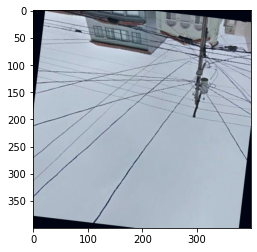

In [18]:
# Example
ds = BuildingImagesDataset(df)
translate_back = {v:k for k, v in ds.label_dict.items()}
img = np.transpose(ds[1994][0], (1, 2, 0))
print(translate_back[ds[1994][1].item()])
plt.imshow(img);

- Create training and validation DataLoaders

In [20]:
from sklearn.model_selection import train_test_split

batch_size = 30

df_train, df_test = train_test_split(df)
df_train, df_valid = train_test_split(df_train)

ds_train = BuildingImagesDataset(df_train)
ds_valid = BuildingImagesDataset(df_valid)

dl_train = DataLoader(ds_train, batch_size = batch_size, shuffle=True)
dl_valid = DataLoader(ds_valid, batch_size = batch_size, shuffle=False)

In [34]:
# debugging the dataset, cv2.cvtColor errors out in training for faulty pictures

# for i in range(len(df_train.index)):
#     row = df_train.iloc[i]
    
#     try:
#         path = row['image_path'] + f"/{row['image_file']}"
#         img = cv2.imread(path)
#         img = cv2.cvtColor(img, cv2. COLOR_BGR2RGB)
    
#     except:
#         print(row['image_path'] + f"/{row['image_file']}")

# Create CNN Model:

In [10]:
dir(models)

# clear the cache if running out of memory
# torch.cuda.empty_cache()

['AlexNet',
 'DenseNet',
 'GoogLeNet',
 'GoogLeNetOutputs',
 'Inception3',
 'InceptionOutputs',
 'MNASNet',
 'MobileNetV2',
 'MobileNetV3',
 'ResNet',
 'ShuffleNetV2',
 'SqueezeNet',
 'VGG',
 '_GoogLeNetOutputs',
 '_InceptionOutputs',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_utils',
 'alexnet',
 'densenet',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'detection',
 'googlenet',
 'inception',
 'inception_v3',
 'mnasnet',
 'mnasnet0_5',
 'mnasnet0_75',
 'mnasnet1_0',
 'mnasnet1_3',
 'mobilenet',
 'mobilenet_v2',
 'mobilenet_v3_large',
 'mobilenet_v3_small',
 'mobilenetv2',
 'mobilenetv3',
 'quantization',
 'resnet',
 'resnet101',
 'resnet152',
 'resnet18',
 'resnet34',
 'resnet50',
 'resnext101_32x8d',
 'resnext50_32x4d',
 'segmentation',
 'shufflenet_v2_x0_5',
 'shufflenet_v2_x1_0',
 'shufflenet_v2_x1_5',
 'shufflenet_v2_x2_0',
 'shufflenetv2',
 'squeezenet',
 'squeezenet1_0',
 '

- Tweak the final layer and create directory to save both models and parameter checkpoints

In [30]:
#resnet = models.resnet18(pretrained=True)
today = str(date.today())
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(512, 4, bias=True)

directory = 'resnet18'
!mkdir models/$directory
!mkdir models/$directory/model_checkpoints

mkdir: cannot create directory ‘models/resnet18’: File exists
mkdir: cannot create directory ‘models/resnet18/model_checkpoints’: File exists


- (Optional) exploration of structure and toggling the freezing/unfreezing of gradients

In [13]:
# from torchsummary import summary
# summary(model, input_size = (3, 400, 400), device='cpu')

In [14]:
# for param in model.parameters():
#             param.requires_grad = False
        

# for name, param in model.named_parameters():
#     print(f"{name} gradient is set to", param.requires_grad)

# Connect to GPU // Create Training Loop

In [16]:
torch.cuda.is_available()
#!nvidia-smi

True

In [17]:
device = torch.device(0)
model.to(device)
print("model successfully made it onto GPU")

model successfully made it onto GPU


In [22]:
# credit: Kamron Ajfshar
def create_optimizer(model, lr0):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    return optim.Adam(parameters,lr=lr0, weight_decay=1e-5)

def update_optimizer(optimizer, lr0):
    optimizer.param_groups[0]["lr"] = lr0

def cosine_segment(start_lr, end_lr, iterations):
    i = np.arange(iterations)
    c_i = 1 + np.cos(i*np.pi/iterations)
    return end_lr + (start_lr - end_lr)/2 *c_i

def get_cosine_triangular_lr(max_lr, iterations):
    min_start, min_end = max_lr/25, max_lr/(25*1e4)
    iter1 = int(0.3*iterations)
    iter2 = iterations - iter1
    segs = [cosine_segment(min_start, max_lr, iter1), cosine_segment(max_lr, min_end, iter2)]
    return np.concatenate(segs)

In [23]:
def one_pass(model, dataloader, optimizer, lossFun, lrs, idx, backwards=True, print_loss=False):
    if backwards == True:
        model.train()
    else:
        model.eval()
    
    total_loss = 0.0
    for x, y in tqdm(dataloader):
        if backwards == True:
            lr = lrs[idx]
            update_optimizer(optimizer, lr)
            
        x, y = x.to(device), y.to(device)
        
        y_pred = model(x)
        loss = lossFun(y_pred, y)
        total_loss += loss.item()
        
        if backwards == True:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            idx += 1
            
    avg_loss = total_loss / len(dataloader)
    
    if print_loss == True:
        print(avg_loss)
    
    return avg_loss, idx

def one_pass_acc(model, dataloader, num_points):
    model.eval()
    total_incorrect = 0
    
    softmax = nn.LogSoftmax(dim=1)
    
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        y_pred = softmax(model(x))
        y_pred = torch.argmax(y_pred, dim=1)
        
        total_incorrect += torch.count_nonzero(y - y_pred).item()
        
    percent_wrong = total_incorrect / num_points
    return 1 - percent_wrong

# Fine Tuning the Model

In [21]:
# Debugging optimizer update loop

# all_params = []

# for name, param in resnet.named_parameters():
#     param.requires_grad = False
#     all_params.append(param)
    
# for param in all_params[-2:]:
#     param.requires_grad = True

# step = 62 // num_epochs

# for i in range(1, num_epochs + 1):
#     print("Epoch: ", i)
#     for param in all_params[-i*step:]:
#         param.requires_grad = True

#     for name, param in resnet.named_parameters():
#             print(param.requires_grad)

In [26]:
def update_grads(model, i, num_epochs):
    """Unfreezes and 'steps' numbers of layers each epoch"""
    step = num_layers // num_epochs
    
    all_params = []
    
    for name, param in model.named_parameters():
        all_params.append(param)
        
    for param in all_params[-i*step:]:
        param.requires_grad = True

    params = optimizer_params(model)
        
    optimizer = optim.AdamW(params, lr=0.01)

    return optimizer


def optimizer_params(model, max_lr=0.01):
    """
    Scales the optimizer parameters:
    learning rate
    """

    # The deeper into the model, the smaller the learning rate
    params = []
    
    for i, layer in enumerate(model.children()):
        if i < 6:
            params.append({'params': layer.parameters(), 'lr': max_lr / 100})
        elif 5 < i < 9:
            params.append({'params': layer.parameters(), 'lr': max_lr / 10})
        else:
            params.append({'params': layer.parameters()})

    return params

params = optimizer_params(model)

In [32]:
from tqdm.notebook import tqdm

model = models.resnet18(pretrained=True)
model.fc = nn.Linear(512, 4, bias=True)
num_layers = len(list(model.named_parameters()))
device = torch.device(0)
model.to(device)

lossFun = nn.CrossEntropyLoss()

params_to_update = []

for param in model.parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        
optimizer = optim.AdamW(params_to_update, lr=.1)

num_epochs = 50
train_losses = []
train_accs = []
valid_losses = []
valid_accs = []

iterations = num_epochs*len(dl_train)
lrs = get_cosine_triangular_lr(max_lr=0.01, iterations=iterations)
idx = 0

for i, epoch in tqdm(enumerate(range(num_epochs))):
    print('Epoch: ', epoch)
    
    
    optimizer = update_grads(model, i, num_epochs)
    
    train_loss, idx = one_pass(model, dl_train, optimizer, lossFun, lrs=lrs, idx=idx)
    train_losses.append(train_loss)
    print('Train loss: ', train_loss)
    
    valid_loss, idx = one_pass(model, dl_valid, optimizer, lossFun, lrs=None, idx=idx, backwards=False)
    valid_losses.append(valid_loss)
    print('Valid loss: ', valid_loss)
    
    train_acc = one_pass_acc(model, dl_train, len(ds_train))
    valid_acc = one_pass_acc(model, dl_valid, len(ds_valid))
    print('Train Acc: ', train_acc)
    print('Valid Acc: ', valid_acc)
    
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)
    
    # Save model for the epoch
    model_name = f'models/{directory}/{today}_epoch_{epoch}_tacc_{train_acc:.2f}_vacc_{valid_acc:.2f}.pkl'
    pickle.dump(model, open(model_name, 'wb'))
    
    # Parameter Checkpoint
    checkpoint = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict' :optimizer.state_dict()}
    torch.save(checkpoint, f'models/{directory}/model_checkpoints/{today}_epoch_{epoch}.pt')

0it [00:00, ?it/s]

Epoch:  0


  0%|          | 0/150 [00:00<?, ?it/s]

Train loss:  1.5602382493019105


  0%|          | 0/50 [00:00<?, ?it/s]

Valid loss:  1.4945317912101745
Train Acc:  0.367192709490998
Valid Acc:  0.30533333333333335
Epoch:  1


  0%|          | 0/150 [00:00<?, ?it/s]

Train loss:  1.4535895148913065


  0%|          | 0/50 [00:00<?, ?it/s]

Valid loss:  1.3956935858726502
Train Acc:  0.3036230273394087
Valid Acc:  0.30600000000000005
Epoch:  2


  0%|          | 0/150 [00:00<?, ?it/s]

Train loss:  1.356721405982971


  0%|          | 0/50 [00:00<?, ?it/s]

Valid loss:  1.3535871624946594
Train Acc:  0.42565014447655036
Valid Acc:  0.3413333333333334
Epoch:  3


  0%|          | 0/150 [00:00<?, ?it/s]

Train loss:  1.345539763768514


  0%|          | 0/50 [00:00<?, ?it/s]

Valid loss:  2.046016719341278
Train Acc:  0.3231829295398978
Valid Acc:  0.258
Epoch:  4


  0%|          | 0/150 [00:00<?, ?it/s]

Train loss:  1.3506910570462545


  0%|          | 0/50 [00:00<?, ?it/s]

Valid loss:  1.686198194026947
Train Acc:  0.3365192264947766
Valid Acc:  0.2346666666666667
Epoch:  5


  0%|          | 0/150 [00:00<?, ?it/s]

Train loss:  1.2975244776407877


  0%|          | 0/50 [00:00<?, ?it/s]

Valid loss:  1.6114860224723815
Train Acc:  0.36030228939764397
Valid Acc:  0.33999999999999997
Epoch:  6


  0%|          | 0/150 [00:00<?, ?it/s]

Train loss:  1.26489826242129


  0%|          | 0/50 [00:00<?, ?it/s]

Valid loss:  1.8956238865852355
Train Acc:  0.29562124916648147
Valid Acc:  0.21533333333333338
Epoch:  7


  0%|          | 0/150 [00:00<?, ?it/s]

Train loss:  1.2382457403341929


  0%|          | 0/50 [00:00<?, ?it/s]

Valid loss:  2.0780932211875918
Train Acc:  0.32985107801733715
Valid Acc:  0.2386666666666667
Epoch:  8


  0%|          | 0/150 [00:00<?, ?it/s]

Train loss:  1.2331265266736349


  0%|          | 0/50 [00:00<?, ?it/s]

Valid loss:  1.497661530971527
Train Acc:  0.4380973549677706
Valid Acc:  0.33333333333333337
Epoch:  9


  0%|          | 0/150 [00:00<?, ?it/s]

Train loss:  1.2281273782253266


  0%|          | 0/50 [00:00<?, ?it/s]

Valid loss:  1.4442067790031432
Train Acc:  0.45810180040008885
Valid Acc:  0.3613333333333333
Epoch:  10


  0%|          | 0/150 [00:00<?, ?it/s]

Train loss:  1.1878935674826303


  0%|          | 0/50 [00:00<?, ?it/s]

Valid loss:  1.346625258922577
Train Acc:  0.4821071349188708
Valid Acc:  0.3606666666666667
Epoch:  11


  0%|          | 0/150 [00:00<?, ?it/s]

Train loss:  1.1617064170042675


  0%|          | 0/50 [00:00<?, ?it/s]

Valid loss:  1.426657223701477
Train Acc:  0.4861080240053345
Valid Acc:  0.3633333333333333
Epoch:  12


  0%|          | 0/150 [00:00<?, ?it/s]

Train loss:  1.1459665485223134


  0%|          | 0/50 [00:00<?, ?it/s]

Valid loss:  1.401216950416565
Train Acc:  0.46276950433429653
Valid Acc:  0.3373333333333334
Epoch:  13


  0%|          | 0/150 [00:00<?, ?it/s]

Train loss:  1.1202427168687186


  0%|          | 0/50 [00:00<?, ?it/s]

Valid loss:  1.8339590430259705
Train Acc:  0.37586130251166927
Valid Acc:  0.2546666666666667
Epoch:  14


  0%|          | 0/150 [00:00<?, ?it/s]

Train loss:  1.1037058063348135


  0%|          | 0/50 [00:00<?, ?it/s]

Valid loss:  1.690359854698181
Train Acc:  0.3851967103800845
Valid Acc:  0.23133333333333328
Epoch:  15


  0%|          | 0/150 [00:00<?, ?it/s]

Train loss:  1.088988075653712


  0%|          | 0/50 [00:00<?, ?it/s]

Valid loss:  1.5345539879798888
Train Acc:  0.448544120915759
Valid Acc:  0.28
Epoch:  16


  0%|          | 0/150 [00:00<?, ?it/s]

Train loss:  1.0843780577182769


  0%|          | 0/50 [00:00<?, ?it/s]

Valid loss:  1.5259414887428284
Train Acc:  0.4158701933763058
Valid Acc:  0.2846666666666666
Epoch:  17


  0%|          | 0/150 [00:00<?, ?it/s]

Train loss:  1.0558737802505493


  0%|          | 0/50 [00:00<?, ?it/s]

Valid loss:  1.6311952233314515
Train Acc:  0.4816625916870416
Valid Acc:  0.29733333333333334
Epoch:  18


  0%|          | 0/150 [00:00<?, ?it/s]

Train loss:  1.0405472822984059


  0%|          | 0/50 [00:00<?, ?it/s]

Valid loss:  1.490461299419403
Train Acc:  0.5163369637697266
Valid Acc:  0.32666666666666666
Epoch:  19


  0%|          | 0/150 [00:00<?, ?it/s]

Train loss:  1.027328168551127


  0%|          | 0/50 [00:00<?, ?it/s]

Valid loss:  1.539329948425293
Train Acc:  0.5230051122471661
Valid Acc:  0.346
Epoch:  20


  0%|          | 0/150 [00:00<?, ?it/s]

Train loss:  1.0058836909135183


  0%|          | 0/50 [00:00<?, ?it/s]

Valid loss:  1.6500777053833007
Train Acc:  0.524338741942654
Valid Acc:  0.32466666666666666
Epoch:  21


  0%|          | 0/150 [00:00<?, ?it/s]

Train loss:  0.9917138747374217


  0%|          | 0/50 [00:00<?, ?it/s]

Valid loss:  1.8267092967033387
Train Acc:  0.5176705934652145
Valid Acc:  0.3406666666666667
Epoch:  22


  0%|          | 0/150 [00:00<?, ?it/s]

Train loss:  0.990708532333374


  0%|          | 0/50 [00:00<?, ?it/s]

Valid loss:  1.6936945772171021
Train Acc:  0.5650144476550345
Valid Acc:  0.352
Epoch:  23


  0%|          | 0/150 [00:00<?, ?it/s]

Train loss:  0.9623689925670624


  0%|          | 0/50 [00:00<?, ?it/s]

Valid loss:  1.6594575142860413
Train Acc:  0.5907979551011335
Valid Acc:  0.3446666666666667
Epoch:  24


  0%|          | 0/150 [00:00<?, ?it/s]

Train loss:  0.9525669074058533


  0%|          | 0/50 [00:00<?, ?it/s]

Valid loss:  1.7445654940605164
Train Acc:  0.5796843743054012
Valid Acc:  0.3873333333333333
Epoch:  25


  0%|          | 0/150 [00:00<?, ?it/s]

Train loss:  0.9145767796039581


  0%|          | 0/50 [00:00<?, ?it/s]

Valid loss:  1.7343821430206299
Train Acc:  0.5999110913536341
Valid Acc:  0.3946666666666667
Epoch:  26


  0%|          | 0/150 [00:00<?, ?it/s]

Train loss:  0.8947405707836151


  0%|          | 0/50 [00:00<?, ?it/s]

Valid loss:  1.7576428198814391
Train Acc:  0.6121360302289398
Valid Acc:  0.3866666666666667
Epoch:  27


  0%|          | 0/150 [00:00<?, ?it/s]

Train loss:  0.886775058110555


  0%|          | 0/50 [00:00<?, ?it/s]

Valid loss:  1.876695189476013
Train Acc:  0.6363636363636364
Valid Acc:  0.41866666666666663
Epoch:  28


  0%|          | 0/150 [00:00<?, ?it/s]

Train loss:  0.8565589151779811


  0%|          | 0/50 [00:00<?, ?it/s]

Valid loss:  2.378542699813843
Train Acc:  0.5163369637697266
Valid Acc:  0.266
Epoch:  29


  0%|          | 0/150 [00:00<?, ?it/s]

Train loss:  0.8490826034545899


  0%|          | 0/50 [00:00<?, ?it/s]

Valid loss:  1.789910111427307
Train Acc:  0.60880195599022
Valid Acc:  0.394
Epoch:  30


  0%|          | 0/150 [00:00<?, ?it/s]

Train loss:  0.8380772260824839


  0%|          | 0/50 [00:00<?, ?it/s]

Valid loss:  2.1277455425262453
Train Acc:  0.5872416092464992
Valid Acc:  0.33599999999999997
Epoch:  31


  0%|          | 0/150 [00:00<?, ?it/s]

Train loss:  0.8091286132733028


  0%|          | 0/50 [00:00<?, ?it/s]

Valid loss:  2.017629461288452
Train Acc:  0.612580573460769
Valid Acc:  0.3733333333333333
Epoch:  32


  0%|          | 0/150 [00:00<?, ?it/s]

Train loss:  0.8186442104975382


  0%|          | 0/50 [00:00<?, ?it/s]

Valid loss:  1.8295022940635681
Train Acc:  0.6908201822627251
Valid Acc:  0.3666666666666667
Epoch:  33


  0%|          | 0/150 [00:00<?, ?it/s]

Train loss:  0.7708126006523768


  0%|          | 0/50 [00:00<?, ?it/s]

Valid loss:  2.1564510107040404
Train Acc:  0.6456990442320516
Valid Acc:  0.32933333333333337
Epoch:  34


  0%|          | 0/150 [00:00<?, ?it/s]

Train loss:  0.7804632437229156


  0%|          | 0/50 [00:00<?, ?it/s]

Valid loss:  2.0354213547706603
Train Acc:  0.6968215158924205
Valid Acc:  0.386
Epoch:  35


  0%|          | 0/150 [00:00<?, ?it/s]

Train loss:  0.7507492490609486


  0%|          | 0/50 [00:00<?, ?it/s]

Valid loss:  2.0492641806602476
Train Acc:  0.6854856634807736
Valid Acc:  0.43333333333333335
Epoch:  36


  0%|          | 0/150 [00:00<?, ?it/s]

Train loss:  0.7308105840285619


  0%|          | 0/50 [00:00<?, ?it/s]

Valid loss:  2.193762683868408
Train Acc:  0.6510335630140032
Valid Acc:  0.3746666666666667
Epoch:  37


  0%|          | 0/150 [00:00<?, ?it/s]

Train loss:  0.7533173807462057


  0%|          | 0/50 [00:00<?, ?it/s]

Valid loss:  2.041401484012604
Train Acc:  0.7057123805290064
Valid Acc:  0.3466666666666667
Epoch:  38


  0%|          | 0/150 [00:00<?, ?it/s]

Train loss:  0.6983560878038406


  0%|          | 0/50 [00:00<?, ?it/s]

Valid loss:  2.099610753059387
Train Acc:  0.7010446765947989
Valid Acc:  0.3606666666666667
Epoch:  39


  0%|          | 0/150 [00:00<?, ?it/s]

Train loss:  0.6919824635982513


  0%|          | 0/50 [00:00<?, ?it/s]

Valid loss:  2.0693003225326536
Train Acc:  0.7570571238052901
Valid Acc:  0.3926666666666667
Epoch:  40


  0%|          | 0/150 [00:00<?, ?it/s]

Train loss:  0.655324343641599


  0%|          | 0/50 [00:00<?, ?it/s]

Valid loss:  2.205893461704254
Train Acc:  0.7428317403867526
Valid Acc:  0.3646666666666667
Epoch:  41


  0%|          | 0/150 [00:00<?, ?it/s]

Train loss:  0.6513758820295333


  0%|          | 0/50 [00:00<?, ?it/s]

Valid loss:  2.3631000828742983
Train Acc:  0.7119359857746166
Valid Acc:  0.3793333333333333
Epoch:  42


  0%|          | 0/150 [00:00<?, ?it/s]

Train loss:  0.630324111978213


  0%|          | 0/50 [00:00<?, ?it/s]

Valid loss:  2.399344215393066
Train Acc:  0.7695043342965103
Valid Acc:  0.398
Epoch:  43


  0%|          | 0/150 [00:00<?, ?it/s]

Train loss:  0.6231569457054138


  0%|          | 0/50 [00:00<?, ?it/s]

Valid loss:  2.4369830894470215
Train Acc:  0.7795065570126695
Valid Acc:  0.374
Epoch:  44


  0%|          | 0/150 [00:00<?, ?it/s]

Train loss:  0.6108760396639507


  0%|          | 0/50 [00:00<?, ?it/s]

Valid loss:  2.5330039262771606
Train Acc:  0.7715047788397422
Valid Acc:  0.3846666666666667
Epoch:  45


  0%|          | 0/150 [00:00<?, ?it/s]

Train loss:  0.5968422867854436


  0%|          | 0/50 [00:00<?, ?it/s]

Valid loss:  2.3584816551208494
Train Acc:  0.7966214714380974
Valid Acc:  0.3986666666666666
Epoch:  46


  0%|          | 0/150 [00:00<?, ?it/s]

Train loss:  0.5610472356279691


  0%|          | 0/50 [00:00<?, ?it/s]

Valid loss:  2.593805630207062
Train Acc:  0.8108468548566348
Valid Acc:  0.4033333333333333
Epoch:  47


  0%|          | 0/150 [00:00<?, ?it/s]

Train loss:  0.5559165655573209


  0%|          | 0/50 [00:00<?, ?it/s]

Valid loss:  2.6525857281684875
Train Acc:  0.7850633474105357
Valid Acc:  0.3766666666666667
Epoch:  48


  0%|          | 0/150 [00:00<?, ?it/s]

Train loss:  0.5629213270545006


  0%|          | 0/50 [00:00<?, ?it/s]

Valid loss:  2.704481828212738
Train Acc:  0.8215158924205379
Valid Acc:  0.406
Epoch:  49


  0%|          | 0/150 [00:00<?, ?it/s]

Train loss:  0.5320802513758341


  0%|          | 0/50 [00:00<?, ?it/s]

Valid loss:  2.7651239085197448
Train Acc:  0.8124027561680374
Valid Acc:  0.41200000000000003


# Analysis:

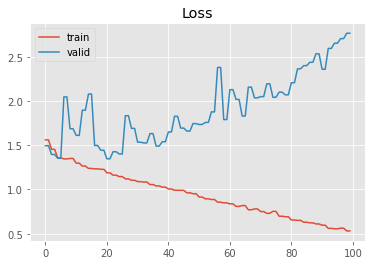

In [33]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

plt.plot(train_losses, label = 'train') 
plt.plot(valid_losses, label = 'valid')
plt.title('Loss')
plt.legend()
plt.show()

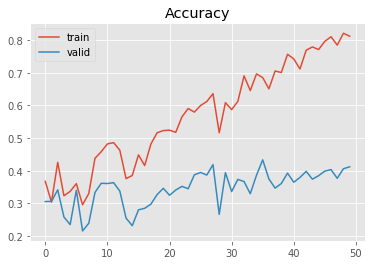

In [34]:
plt.plot(train_accs, label='train')
plt.plot(valid_accs, label='valid')
plt.title('Accuracy')
plt.legend()
plt.show()

# Confusion Matrix (Validation Set)

In [71]:
def predictions(model, dataloader, num_points):
    model.eval()
    total_incorrect = 0
    
    softmax = nn.LogSoftmax(dim=1)
    y_preds = []
    ys = []
    for x, y in tqdm(dataloader):
        x = x.to(device)
        y_pred = softmax(model(x))
        y_pred = torch.argmax(y_pred, dim=1)
        
        y_preds.extend(y_pred.cpu().detach().numpy().tolist())
        ys.extend(y.detach().numpy().tolist())

    return y_preds, ys

y_preds, ys = predictions(model, dl_valid, len(ds_valid))

  0%|          | 0/50 [00:00<?, ?it/s]

In [72]:
to_label = {val:key for key, val in ds_valid.label_dict.items()}
y_pred_label = [to_label[y] for y in y_preds]
y_true_label = [to_label[y] for y in ys]

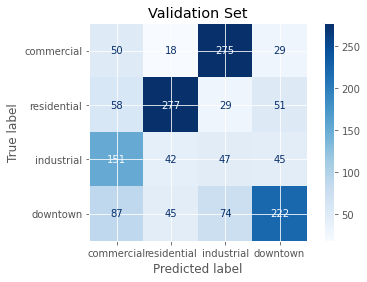

In [73]:
from sklearn import metrics
labels = list(ds_valid.label_dict.keys())
cm = metrics.confusion_matrix(y_pred_label, y_true_label, labels=labels)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues, values_format='g')
plt.title('Validation Set');

In [76]:
from sklearn.metrics import classification_report
print(classification_report(y_preds, ys, target_names=labels))

              precision    recall  f1-score   support

  commercial       0.14      0.13      0.14       372
 residential       0.73      0.67      0.70       415
  industrial       0.11      0.16      0.13       285
    downtown       0.64      0.52      0.57       428

    accuracy                           0.40      1500
   macro avg       0.40      0.37      0.38      1500
weighted avg       0.44      0.40      0.42      1500



# Confusion Matrix (Training Set)

In [77]:
y_preds, ys = predictions(model, dl_train, len(ds_train))

  0%|          | 0/150 [00:00<?, ?it/s]

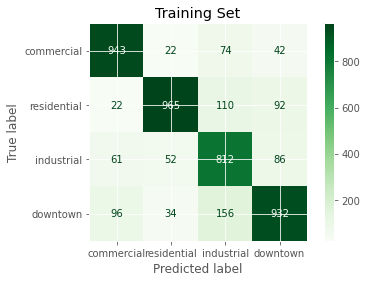

In [78]:
y_pred_label = [to_label[y] for y in y_preds]
y_true_label = [to_label[y] for y in ys]

cm = metrics.confusion_matrix(y_pred_label, y_true_label, labels=labels)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Greens, values_format='g')
plt.title('Training Set');

In [79]:
print(classification_report(y_preds, ys, target_names=labels))

              precision    recall  f1-score   support

  commercial       0.84      0.87      0.86      1081
 residential       0.90      0.81      0.85      1189
  industrial       0.70      0.80      0.75      1011
    downtown       0.81      0.77      0.79      1218

    accuracy                           0.81      4499
   macro avg       0.81      0.81      0.81      4499
weighted avg       0.82      0.81      0.81      4499



# Loading Parameters/Model

In [ ]:
# # now load them up!
# checkpoint = torch.load('model_checkpoint.pt')
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# load the model from disk
# loaded_model = pickle.load(open(filename, 'rb'))

In [35]:
!pwd

/home/oniemann/Resilience_Classifier
